<a href="https://colab.research.google.com/github/ngupta23/medium_articles/blob/main/time_series/pycaret/pycaret_ts_arima_000_010s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previous Article(s) in this Series
* [A Practical Guide to ARIMA Models using PyCaret — Part 1 (Statistical Overview)](https://towardsdatascience.com/understanding-arima-models-using-pycarets-time-series-module-part-1-692e10ca02f2)
* [A Practical Guide to ARIMA Models using PyCaret — Part 2 (Understanding the Trend Term)](https://towardsdatascience.com/understanding-arima-models-using-pycarets-time-series-module-part2-308ea7bfecf6)
* [A Practical Guide to ARIMA Models using PyCaret — Part 3 (Understanding the Difference Term](https://towardsdatascience.com/a-practical-guide-to-arima-models-using-pycaret-part-3-823abb5359a7)

## Install & Import Library




In [1]:
try:
  import pycaret
except:
  !pip install pycaret-ts-alpha

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from pycaret.datasets import get_data
from pycaret.internal.pycaret_experiment import TimeSeriesExperiment
from sklearn.linear_model import LinearRegression

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Get Data and Setup PyCaret Experiment

In [3]:
#### Get data from data playground ----
y = get_data("airline")

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64

In [4]:
exp = TimeSeriesExperiment()
exp.setup(data=y, fh=12, session_id=42)

,Description,Value
0,session_id,42
1,Original Data,"(144, 1)"
2,Missing Values,False
3,Transformed Train Set,"(132,)"
4,Transformed Test Set,"(12,)"
5,Fold Generator,ExpandingWindowSplitter
6,Fold Number,3
7,Enforce Prediction Interval,False
8,Seasonal Period Tested,12
9,Seasonality Detected,True


## EDA

In [5]:
exp.plot_model()

In [6]:
exp.plot_model(plot="acf")
exp.plot_model(plot="pacf", data_kwargs={"nlags": 24})

## Helper functions using PyCaret's Time Series Module

In [7]:
def summarize_model(model):
  """
  Provides statistical summary for some statistical models
  """
  # Statistical Summary Table
  try:
    print(model.summary())
  except:
    print("Summary does not exist for this model.")

In [8]:
def get_residual_properties(model, sp=None):
  """
  Plots and displays variance of residuals
  sp = seasonal period; if specified, the first sp points are ignored while calculating Sigma2
  """
  #### Residuals ----
  try:
    plot_data = exp.plot_model(model, plot="residuals", return_data=True)
    resid = plot_data['data']
    if sp is not None:
      resid = resid[sp:]
    resid_sigma2 = (resid**2).sum()/(len(resid))
    print(f"Residual Sigma 2: {resid_sigma2}")
  except:
    print("Residuals can not be extracted for this model.")

In [9]:
def plot_predictions(model):
  """
  Plots out-of-sample and in-sample predictions
  """
  # Out-of-Sample Forecast
  exp.plot_model(model)
  
  # In-Sample Forecast
  exp.plot_model(model, plot="insample")

## Train & Test Data Properties

In [10]:
# Get Train Data Properties
y_train = exp.get_config("y_train")
print(f"Train Start Index: {y_train.index.min()}\nTrain End Index: {y_train.index.max()}")

# Get Test Data Properties
y_test = exp.get_config("y_test")
print(f"Test Start Index: {y_test.index.min()}\nTest End Index: {y_test.index.max()}")

Train Start Index: 1949-01
Train End Index: 1959-12
Test Start Index: 1960-01
Test End Index: 1960-12


## Seasonal ARIMA Model

### Theoretical Calculations

#### Seasonal Model without Trend

In [11]:
y_train.iloc[-12:]

1959-01    360.0
1959-02    342.0
1959-03    406.0
1959-04    396.0
1959-05    420.0
1959-06    472.0
1959-07    548.0
1959-08    559.0
1959-09    463.0
1959-10    407.0
1959-11    362.0
1959-12    405.0
Freq: M, Name: Number of airline passengers, dtype: float64

In [12]:
train_data = pd.DataFrame({"y":y_train})
train_data['preds'] = y_train.shift(12).fillna(0)
train_data['split'] = "Train"

test_data = pd.DataFrame({'y': y_test})
test_data['preds'] = y_train.iloc[-12:].values
test_data['split'] = "Test"

data = pd.concat([train_data, test_data])
data['residuals'] = data['y'] - data['preds']
data.index = data.index.to_timestamp()
data.reset_index(inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index      144 non-null    datetime64[ns]
 1   y          144 non-null    float64       
 2   preds      144 non-null    float64       
 3   split      144 non-null    object        
 4   residuals  144 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 5.8+ KB


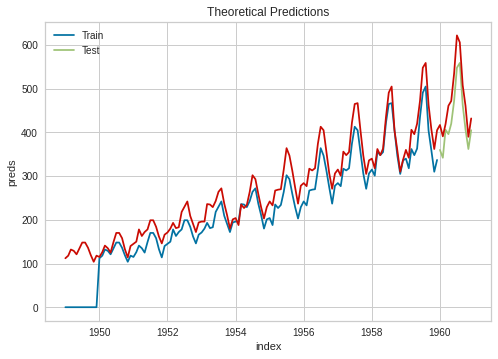

In [13]:
sns.lineplot(data=data, x="index", y="preds", hue="split").set(title="Theoretical Predictions")
sns.lineplot(data=data, x="index", y="y", color='r', legend="auto")

#### Seasonal Model with trend = "c"

In [14]:
# For fitting linear regression, 1st seasonal period is ignored since it does 
# not have enough historical points to compute realistic residuals
y_for_lr = data.query("split=='Train'").iloc[12:]['residuals'].dropna()
y_for_lr.mean()

30.166666666666668

#### Seasonal Model with trend = "t"

In [15]:
# For fitting linear regression, 1st seasonal period is ignored since it does 
# not have enough historical points to compute realistic residuals
y_for_lr = data.query("split=='Train'").iloc[12:]['residuals'].dropna()

# Note that X starts from appropriate point in time (not from time t=0)
X_train = np.arange(12, len(y_train)).reshape(-1, 1)

reg = LinearRegression(fit_intercept=False).fit(X_train, y_for_lr)
print(f"Expected Intercept: {reg.intercept_}")
print(f"Expected Slope: {reg.coef_}")

Expected Intercept: 0.0
Expected Slope: [0.37410292]


#### Seasonal Model with trend = "ct"

In [16]:
# For fitting linear regression, 1st seasonal period is ignored since it does 
# not have enough historical points to compute realistic residuals
y_for_lr = data.query("split=='Train'").iloc[12:]['residuals'].dropna()

# Note that X starts from appropriate point in time (not from time t=0)
X_train = np.arange(12, len(y_train)).reshape(-1, 1)

reg = LinearRegression(fit_intercept=True).fit(X_train, y_for_lr)
print(f"Expected Intercept: {reg.intercept_}")
print(f"Expected Slope: {reg.coef_}")

Expected Intercept: 17.982021899668958
Expected Slope: [0.17041461]


### Now let's build this model & compare to Theory

#### Naive Seasonal Model without Trend

In [17]:
model4a = exp.create_model("arima", order=(0, 0, 0), seasonal_order=(0, 1, 0, 12), trend="n")

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,R2
0,1956-12,40.1667,41.4749,0.1076,0.1138,1.3755,0.4401
1,1957-12,12.5833,17.0123,0.0314,0.0322,0.4116,0.9242
2,1958-12,47.3333,49.2544,0.1106,0.1176,1.6565,0.4573
Mean,NaN,33.3611,35.9139,0.0832,0.0879,1.1479,0.6072
SD,NaN,14.9806,13.7376,0.0367,0.0394,0.5331,0.2243


In [18]:
summarize_model(model4a)
get_residual_properties(model4a, sp=12)

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                  132
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -595.356
Date:                  Mon, 13 Dec 2021   AIC                           1192.711
Time:                          22:26:31   BIC                           1195.499
Sample:                               0   HQIC                          1193.843
                                  - 132                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1193.3802    247.881      4.814      0.000     707.543    1679.218
Ljung-Box (L1) (Q):                  72.15   Jarque-Bera (JB):                 2.10
Prob(Q):                       

Residual Sigma 2: 1193.5833333333333


In [19]:
plot_predictions(model4a)

In [20]:
exp.check_stats(model4a, test="white_noise")

,Test,Test Name,Property,Setting,Value
0,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 24}",367.022
1,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 48}",382.839
2,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 24}",4.24679e-63
3,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 48}",9.90776e-54
4,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 24}",False
5,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 48}",False


#### Seasonal Model with trend = "c"

In [21]:
model4b = exp.create_model("arima", order=(0, 0, 0), seasonal_order=(0, 1, 0, 12), trend="c")

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,R2
0,1956-12,12.1687,15.3643,0.0304,0.0310,0.4167,0.9232
1,1957-12,18.9323,21.0258,0.0524,0.0508,0.6193,0.8842
2,1958-12,21.1605,23.4388,0.0490,0.0505,0.7405,0.8771
Mean,NaN,17.4205,19.9429,0.0439,0.0441,0.5922,0.8948
SD,NaN,3.8234,3.3842,0.0097,0.0092,0.1336,0.0203


In [22]:
summarize_model(model4b)
get_residual_properties(model4b, sp=12)

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                  132
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -509.117
Date:                  Mon, 13 Dec 2021   AIC                           1022.234
Time:                          22:26:32   BIC                           1027.809
Sample:                               0   HQIC                          1024.498
                                  - 132                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     30.1667      1.540     19.587      0.000      27.148      33.185
sigma2       283.5556     44.344      6.395      0.000     196.644     370.467
Ljung-Box (L1) (Q):                 

Residual Sigma 2: 283.5555555555556


In [23]:
plot_predictions(model4b)

In [24]:
exp.check_stats(model4b, test="white_noise")

,Test,Test Name,Property,Setting,Value
0,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 24}",367.022
1,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 48}",382.839
2,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 24}",4.24679e-63
3,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 48}",9.90776e-54
4,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 24}",False
5,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 48}",False


#### Seasonal Model with trend = "t"

In [25]:
model4c = exp.create_model("arima", order=(0, 0, 0), seasonal_order=(0, 1, 0, 12), trend='t')
model4c

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,R2
0,1956-12,12.6556,14.7210,0.0376,0.0366,0.4334,0.9295
1,1957-12,40.8263,42.5371,0.1121,0.1055,1.3354,0.5260
2,1958-12,10.0588,12.6665,0.0248,0.0246,0.3520,0.9641
Mean,NaN,21.1802,23.3082,0.0582,0.0556,0.7069,0.8065
SD,NaN,13.9323,13.6227,0.0385,0.0356,0.4456,0.1989


ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 0, 12),
      start_params=None, suppress_warnings=False, trend='t',
      with_intercept=True)

In [26]:
summarize_model(model4c)
get_residual_properties(model4c, sp=12)

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                  132
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -514.501
Date:                  Mon, 13 Dec 2021   AIC                           1033.002
Time:                          22:26:33   BIC                           1038.577
Sample:                               0   HQIC                          1035.266
                                  - 132                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.3741      0.021     17.569      0.000       0.332       0.416
sigma2       310.1761     49.522      6.263      0.000     213.114     407.238
Ljung-Box (L1) (Q):                 

Residual Sigma 2: 310.1766912875913


In [27]:
plot_predictions(model4c)

In [28]:
exp.check_stats(model4c, test="white_noise")

,Test,Test Name,Property,Setting,Value
0,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 24}",455.417
1,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 48}",460.749
2,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 24}",2.87676e-81
3,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 48}",8.28938e-69
4,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 24}",False
5,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 48}",False


#### Seasonal Model with trend = "ct"

In [29]:
model4d = exp.create_model("arima", order=(0, 0, 0), seasonal_order=(0, 1, 0, 12), trend="ct")

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,R2
0,1956-12,9.6169,10.9684,0.0274,0.0270,0.3293,0.9608
1,1957-12,33.7582,35.7408,0.0931,0.0884,1.1042,0.6654
2,1958-12,16.5010,18.1780,0.0389,0.0396,0.5775,0.9261
Mean,NaN,19.9587,21.6291,0.0531,0.0517,0.6703,0.8508
SD,NaN,10.1544,10.4035,0.0287,0.0265,0.3231,0.1319


In [30]:
summarize_model(model4d)
get_residual_properties(model4d, sp=12)

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                  132
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -501.250
Date:                  Mon, 13 Dec 2021   AIC                           1008.499
Time:                          22:26:34   BIC                           1016.862
Sample:                               0   HQIC                          1011.895
                                  - 132                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     17.9841      4.133      4.352      0.000       9.884      26.084
drift          0.1704      0.046      3.684      0.000       0.080       0.261
sigma2       248.7085     36.849    

Residual Sigma 2: 248.70860857085785


In [31]:
plot_predictions(model4d)

In [32]:
exp.check_stats(model4d, test="white_noise")

,Test,Test Name,Property,Setting,Value
0,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 24}",386.838
1,White Noise,Ljung-Box,Test Statictic,"{'alpha': 0.05, 'K': 48}",394.954
2,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 24}",3.75709e-67
3,White Noise,Ljung-Box,p-value,"{'alpha': 0.05, 'K': 48}",4.72714e-56
4,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 24}",False
5,White Noise,Ljung-Box,White Noise,"{'alpha': 0.05, 'K': 48}",False


The calculations match exactly with the theoretical calculations. Hopefully this exercise has given us a good understanding of the `s` and `D` components of the ARIMA model. In the next set of articles, we will cover the remaining parameters in the ARIMA model.